In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# from ipywidgets import interactive, widgets
# from IPython.display import display
# from matplotlib.animation import FuncAnimation
from tqdm import tqdm
# import MFKSFVEvolve as fv
from utils import reparameterize, g


/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# parameters

Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e2
r = 1e-2

n_bins = 40

fact = 2
lbd_spl = 6.0

kappa, k, eps, _lbd_spl, r = reparameterize(Drho, Dc, T, epsilon, r)
print(-1 / k * np.log(eps / k / kappa))

# prepare quantities that stay constant during evolution
bin_edges = np.linspace(0, fact * lbd_spl, n_bins+1, endpoint=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
dx = bin_edges[1] - bin_edges[0]
rate_array = r * np.maximum((bin_centers - lbd_spl), 0) #* 1*np.log(1+np.exp((bin_centers-lbd_spl)/1))# 

rate_matrix_transposed = np.zeros((n_bins, n_bins))
rate_matrix_transposed[2 * np.arange(n_bins // 2), np.arange(n_bins // 2)] = rate_array[::2]
rate_matrix_transposed[2 * np.arange(n_bins // 2) + 1, np.arange(n_bins // 2)] = rate_array[1::2]
np.fill_diagonal(rate_matrix_transposed, -0.5 * rate_array)
rate_matrix = rate_matrix_transposed.T

g_array = kappa * np.exp(- k * bin_edges) + eps * bin_edges
g_int_array = kappa * np.exp(- k * bin_centers) * np.sinh(0.5 * k * dx) / (0.5 * k * dx) + eps * bin_centers

# evolution parameters
dt = 0.1
print(f'{dt = }, CFL condition gives dx/max|v| = {dx / np.max(np.abs(g_array)):.2f}')
n_steps = 100_000
stride = 1
mu, sig = 3.4, 2.4
P_ini = 1/np.sqrt(2*np.pi*sig**2) * np.exp(-0.5*(bin_centers - mu)**2/sig**2)
P_ini /= np.sum(P_ini * dx)
norms, means = [], []
P = P_ini.copy()

def get_dynamics_matrix(P, g_int_array, g_array):
    v_array = np.sum(g_int_array * P) / np.sum(P) - g_array
    theta_array = v_array > 0

    dynamics_matrix = np.diag(v_array[:-1] * (1 - theta_array[:-1]) - v_array[1:] * theta_array[1:], k=0)
    dynamics_matrix += np.diag(v_array[1:-1] * theta_array[1:-1], k=-1)
    dynamics_matrix += np.diag(-v_array[1:-1] * (1 - theta_array[1:-1]), k=1)
    
    return dynamics_matrix

for i in tqdm(range(n_steps)):
    if i % stride == 0:
        dynamics_matrix = get_dynamics_matrix(P, g_int_array, g_array)
    P += dt * (dynamics_matrix / dx + rate_matrix) @ P - dt * P * np.sum((dynamics_matrix + rate_matrix * dx) @ P)
    # P /= np.sum(P * dx)
    # P -= dt * ((np.sum(g_int_array * P) / np.sum(P) - g_array[0]) * P[0] + 0.5 * np.sum(rate_array * P * dx)) * P
    norms.append(np.sum(P * dx))
    means.append(np.sum(P * bin_centers * dx))

6.674157244509497
dt = 0.1, CFL condition gives dx/max|v| = 0.20


100%|██████████| 100000/100000 [00:05<00:00, 18068.95it/s]


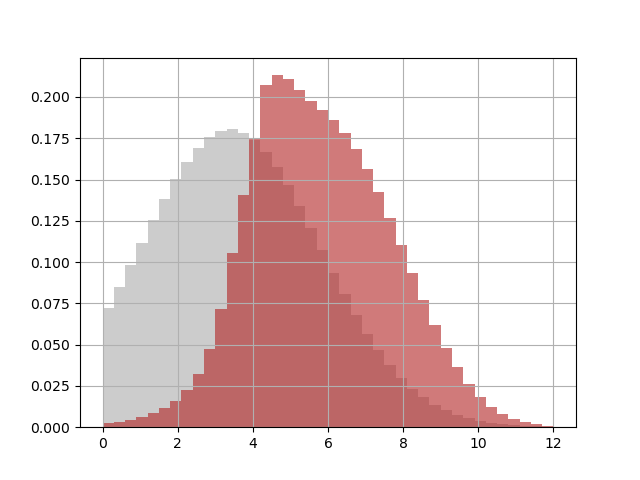

In [3]:
plt.close('all')
fig, ax = plt.subplots()
ax.bar(bin_centers, P_ini, width=dx, color='k', alpha=0.2)
ax.bar(bin_centers, P,     width=dx, color='firebrick', alpha=0.6)
ax.grid()
# ax.set_yscale('log')

In [33]:
ax.bar(bin_centers, P,     width=dx, color='green', alpha=0.6)

<BarContainer object of 40 artists>

In [5]:
ax.bar(bin_centers, res.x,     width=dx, color='blue', alpha=0.6)

<BarContainer object of 40 artists>

In [4]:
from scipy.optimize import root
def RHS(P, g_int_array, g_array, rate_matrix):
    dynamics_matrix = get_dynamics_matrix(P, g_int_array, g_array)
    return (rate_matrix + dynamics_matrix / dx) @ P - P * np.sum((rate_matrix * dx + dynamics_matrix) @ P)

res = root(RHS, x0=P_ini, args=(g_int_array, g_array, rate_matrix), method='krylov', options={'xatol':1e-10, 'maxiter':500})
# res1 = root(RHS, x0=P, args=(g_int_array, g_array, rate_matrix), method='krylov', options={'fatol':1e-8})
print(res.message)
# for method in ["hybr" ,"lm" ,"broyden1" ,"broyden2" ,"anderson" ,"linearmixing" ,"diagbroyden" ,"excitingmixing", "krylov",'df-sane']:
#     try: 
#         root(RHS, x0=P, args=(g_int_array, g_array, rate_matrix), method=method)
#         print(f'Passed {method}')
#     except:
#         print(f'Failed {method}')
#         pass

A solution was found at the specified tolerance.


In [6]:
P = res.x

In [6]:
def RHS_jac(P, g_int_array, g_array, rate_matrix):
    dynamics_matrix = get_dynamics_matrix(P, g_int_array, g_array)

    v_array = np.sum(g_int_array * P) / np.sum(P) - g_array
    theta_array = v_array > 0
    
    _arr = np.zeros_like(P)
    _arr += P * (1 - theta_array[:-1])
    _arr[:-1] -= P[1:] * (1 - theta_array[1:-1])
    _arr -= P * theta_array[1:]
    _arr[1:] += P[:-1] * theta_array[1:-1]

    dRij_dPkPj = dx * _arr[:, None] * g_int_array[None, :]
    
    return rate_matrix + dynamics_matrix / dx - np.identity(len(P)) * np.sum((dx * rate_matrix + dynamics_matrix) @ P) + dRij_dPkPj - dx * P[:, None] * np.sum(dRij_dPkPj + (rate_matrix + dynamics_matrix / dx), axis=0)[None, :]

def RHS_epsilon(P, g_int_array, g_array):
    v_array = np.sum(g_int_array * P) / np.sum(P) - g_array
    theta_array = v_array > 0

    x_mean = np.sum(P * bin_centers * dx)
    x_bin_edges_tilde = x_mean - bin_edges
    
    _matr = np.zeros((n_bins, n_bins+1))
    for i in range(n_bins):
        for j in range(n_bins+1):
            if i==j:
                _matr[i,j] = P[i] * (1 - theta_array[:-1])[i] - (0 if i==n_bins-1 else P[i+1] * theta_array[i+1])
            elif i+1==j and j<n_bins:
                _matr[i,j] = -P[j] * (1 - theta_array[j])
            elif i-1==j:
                _matr[i,j] = (0 if i==n_bins-1 else P[i] * theta_array[i])
    _matr[n_bins-1,n_bins] = -P[n_bins-1] * (1 - theta_array[n_bins-1])

    return reparameterize(Drho, Dc, T, 1.0, 1.0)[2] * (_matr @ x_bin_edges_tilde - P * dx * np.sum(_matr @ x_bin_edges_tilde))

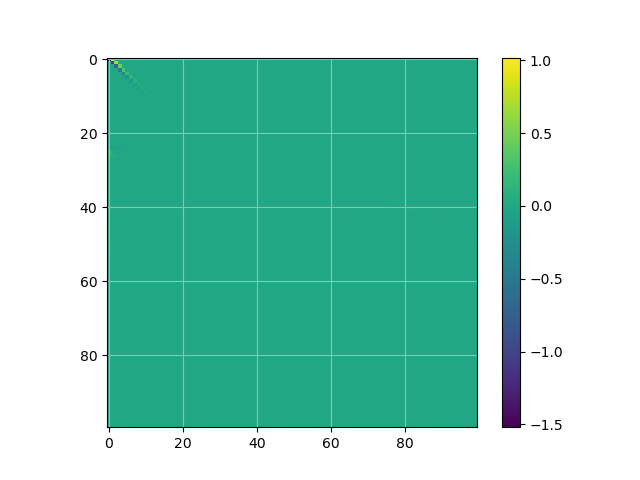

In [32]:
j = RHS_jac(P, g_int_array, g_array, rate_matrix)
# print(np.linalg.eigvals(j))
plt.close('all')
fig, ax = plt.subplots()
_ar = ax.imshow(j, cmap='viridis')
# ax.plot(np.real(np.linalg.eigvals(j)), 'o')
plt.colorbar(_ar)
ax.grid()

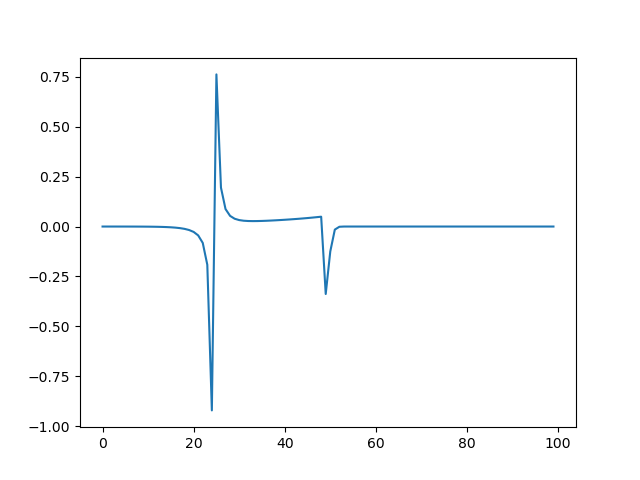

In [ ]:
plt.close('all')
fig, ax = plt.subplots()
# ax.imshow(np.log(np.abs(RHS_epsilon(P, g_int_array, g_array, rate_matrix))))
ax.plot(RHS_epsilon(P, g_int_array, g_array, rate_matrix))
# print(np.sum(RHS_epsilon(P, g_int_array, g_array, rate_matrix), axis=0))

In [ ]:
n_cont = 1000
ds = 10 * np.ones(n_cont)
ds[0] *= 1e-2
maxiter = 500

epsilon_prev = epsilon
kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon_prev, r)

G_s = np.zeros((n_bins+1))
G_s[-1] = 1.0

g_array = kappa * np.exp(- k * bin_edges) + eps * bin_edges
g_int_array = kappa * np.exp(- k * bin_centers) * np.sinh(0.5 * k * dx) / (0.5 * k * dx) + eps * bin_centers
x_s_prev = np.ones(n_bins+1)/np.sqrt(n_bins+1)
x_s_prev[-1] *= 0.01
P_prev = P.copy()

g_array = kappa * np.exp(- k * bin_edges) + eps * bin_edges
g_int_array = kappa * np.exp(- k * bin_centers) * np.sinh(0.5 * k * dx) / (0.5 * k * dx) + eps * bin_centers
G_x = RHS_jac(P_prev, g_int_array, g_array, rate_matrix)
G_L = RHS_epsilon(P_prev, g_int_array, g_array)

E_x = np.block([
    [G_x, G_L[:, None]],
    [x_s_prev[:-1], x_s_prev[-1]]
])

x_s_new = np.linalg.solve(E_x, G_s)
x_s_new /= np.linalg.norm(x_s_new)
x_s_prev = x_s_new.copy()

Ps = []
epsilons = []
stride = 1

# define temp function
def _temp(_x, x_s_prev, x_prev, ds):
    kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, _x[-1], r)
    g_array = kappa * np.exp(- k * bin_edges) + eps * bin_edges
    g_int_array = kappa * np.exp(- k * bin_centers) * np.sinh(0.5 * k * dx) / (0.5 * k * dx) + eps * bin_centers
    return np.hstack([RHS(_x[:-1], g_int_array, g_array, rate_matrix), 
                    np.sum(x_s_prev * (_x - x_prev)) - ds])
                    #   np.sum((_x - np.hstack([P_prev, epsilon_prev]))**2) - ds[i]**2])

# plt.close('all')
# fig, ax = plt.subplots()
# ax.plot(P, 'o', label='Initial P')
for i in range(n_cont):
    # make step 
    P_new = P_prev + ds[i] * x_s_prev[:-1]
    epsilon_new = epsilon_prev + ds[i] * x_s_prev[-1]

    # solve at new value
    res = root(_temp, args=(x_s_prev, np.hstack([P_prev, epsilon_prev]), ds[i]), x0=np.hstack([P_new, epsilon_new]), method='krylov', options={'xatol':1e-8, 'maxiter':maxiter})

    if res.success:
        # get new gradient
        kappa, k, eps, _, r = reparameterize(Drho, Dc, T, res.x[-1], r)
        g_array = kappa * np.exp(- k * bin_edges) + eps * bin_edges
        g_int_array = kappa * np.exp(- k * bin_centers) * np.sinh(0.5 * k * dx) / (0.5 * k * dx) + eps * bin_centers
        G_x = RHS_jac(res.x[:-1], g_int_array, g_array, rate_matrix)
        G_L = RHS_epsilon(res.x[:-1], g_int_array, g_array)

        E_x = np.block([
            [G_x, G_L[:, None]],
            [x_s_prev[:-1], x_s_prev[-1]]
        ])

        x_s_new = np.linalg.solve(E_x, G_s)
        x_s_new /= np.linalg.norm(x_s_new)
        dot_prod_err = 1 - np.sum(x_s_new * x_s_prev)
        if (dot_prod_err < 1e-2) or i<2:
            if i % stride == 0:
                Ps.append(res.x[:-1])
                epsilons.append(res.x[-1])
            
            print(f'iter #: {i+1}', res.message, f'New epsilon: {epsilon_new:.5e}',f'Norm error = {np.abs(1 - np.sum(res.x[:-1] * dx)):.2e}', f'Dot prod err: {dot_prod_err:.2e}', end='\r' if (1 - np.sum(x_s_new * x_s_prev) < 1e-3) else '\n')
            # if i > 1600:
            #     print(f'iter #: {i+1}', res.message, f'New epsilon: {epsilon_new:.5e}',f'Norm error = {np.abs(1 - np.sum(res.x[:-1] * dx)):.2e}', f'Dot prod err: {dot_prod_err:.2e}')

            P_prev = res.x[:-1]
            epsilon_prev = res.x[-1]
            x_s_prev = x_s_new.copy()
            # ds[(i+1)%n_cont:] = ds[i] * 1.1
            # ax.plot(P_prev, 'o-', c=f'C{i}', label=f'P, e = {epsilon_prev:.2e}')
        else:
            print(f'iter #: {i+1}', res.message, f'Dot prod err: {dot_prod_err:.2e}', f'Repeating step with ds = {ds[i]/2:.2e}', end='\n')
            ds[(i+1)%n_cont:] = ds[i] / 2

    else:
        print(f'iter #: {i+1}', res.message, f'Repeating step with ds = {ds[i]/2:.2e}')
        if ds[i] > 1e-7:
            ds[(i+1)%n_cont:] = ds[i] / 2
        else:
            maxiter += 100

    # ax.plot(ds * x_s_new, 'o-.', c=f'C{i}', label=f'D P {i}')
    # ax.plot(P_new, 'o--', c=f'C{i}', label=f'P guess {i}')

# ax.set_yscale('log')
# ax.legend(bbox_to_anchor=(1.1, 1.05))
# ax.grid()
# plt.show()

iter #: 93 The maximum number of iterations allowed has been reached. Repeating step with ds = 5.00e+00-13 Dot prod err: 8.31e-07


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

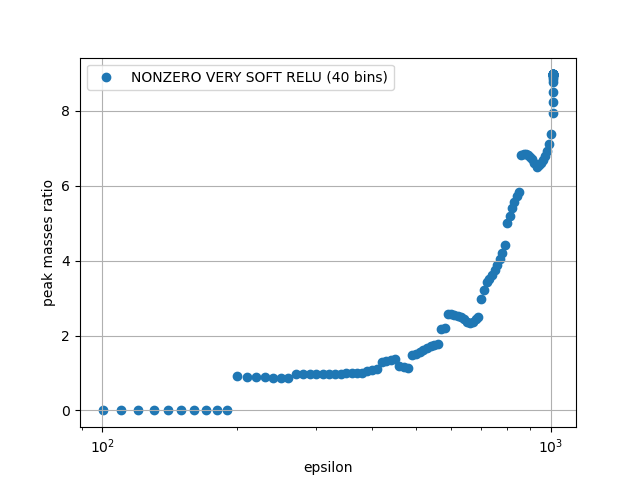

In [19]:
from scipy.signal import find_peaks
lows, hihs = [], []
plt.close('all')
fig, ax = plt.subplots()
for i in range(len(epsilons)):
    inds, dic = find_peaks(Ps[i], height=0.00001)
    # lows.append(dic['peak_heights'][0])
    # try:
    #     hihs.append(dic['peak_heights'][1])
    # except:
    #     hihs.append(0.0)
    try:
        lows.append(sum(Ps[i][inds[0]-2:inds[0]+2]))
    except:
        lows.append(0.0)
    try:
        hihs.append(sum(Ps[i][inds[1]-2:inds[1]+2]))
    except:
        hihs.append(0.0)
lows, hihs = np.array(lows), np.array(hihs)

# ax.scatter(epsilons, lows)
# ax.scatter(epsilons, hihs)
ax.scatter(epsilons, hihs/lows, label=f'NONZERO VERY SOFT RELU ({n_bins} bins)')

# from scipy.optimize import root_scalar
# fr, sr = [], []
# for i in range(len(epsilons)):

#     _kappa, _k, _eps, _, _ = reparameterize(Drho, Dc, T, epsilons[i], r)
#     _g_int_array = _kappa * np.exp(- _k * bin_centers) * np.sinh(0.5 * k * dx) / (0.5 * k * dx) + _eps * bin_centers
#     _g_mean = np.sum(_g_int_array * Ps[i]) / np.sum(Ps[i])
#     first_root = root_scalar(lambda x: _kappa * np.exp(- _k * x) + _eps * x - _g_mean, bracket=(-1/_k * np.log(_g_mean/_kappa), -1/_k * np.log(_eps/_kappa)))
#     # first_root = root_scalar(lambda x: _kappa * np.exp(- _k * x) + _eps * x - _g_mean, method='bisect', bracket=(0, -np.log(_eps/_kappa)))
#     second_root = root_scalar(lambda x: _kappa * np.exp(- _k * x) + _eps * x - _g_mean, bracket=(-1/_k * np.log(_eps/_kappa), _g_mean / _eps))
#     # second_root = root_scalar(lambda x: _kappa * np.exp(- _k * x) + _eps * x - _g_mean, method='bisect', bracket=(-np.log(_eps/_kappa), 2*lbd_spl))
#     fr.append(-_kappa * np.exp(-first_root.root) + _eps)
#     sr.append(-_kappa * np.exp(-second_root.root) + _eps)
# # ax.scatter(epsilons, fr)
# ax.scatter(epsilons, [-fr[i]/sr[i] for i in range(len(epsilons))])
ax.grid()
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('epsilon')
ax.set_ylabel('peak masses ratio')
plt.show()

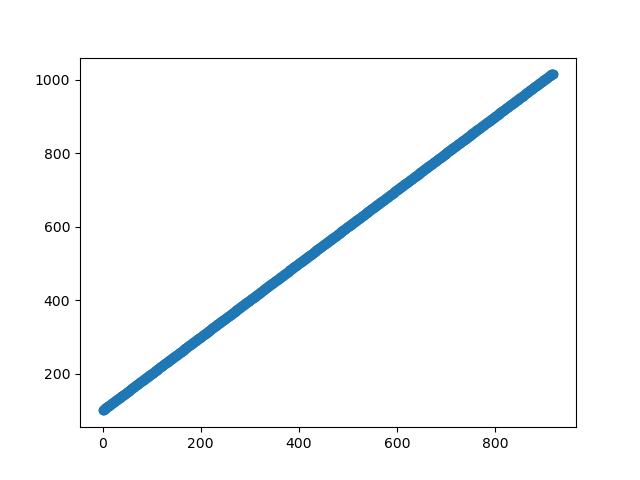

In [13]:
fig, ax = plt.subplots()
ax.plot(epsilons, 'o')

No handles with labels found to put in legend.


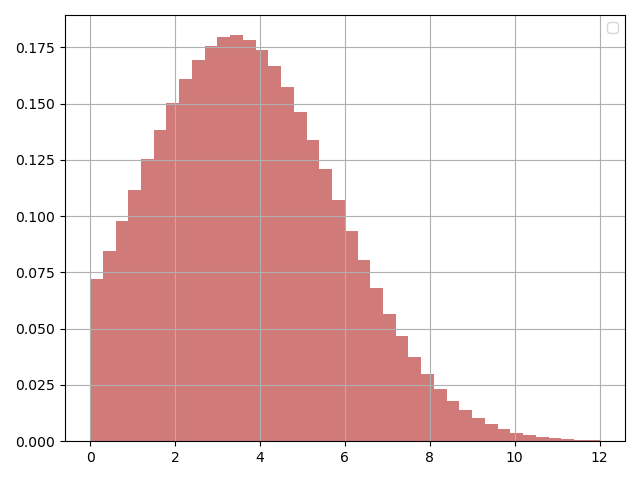

In [20]:
from matplotlib.animation import FuncAnimation
# animate P(t)
num_frames = len(epsilons)

# Initial state
# P = P_ini

# Initialize plot
plt.close('all')
fig, ax = plt.subplots()
bars = ax.bar(bin_centers, P_ini, width=dx, color='firebrick', alpha=0.6)
time_text = ax.text(0.02, 0.93, '', transform=ax.transAxes)
ax.legend()
ax.grid()

# Variables to store statistics over time
times = []
stats1 = []
stats2 = []
stats3 = []


# Update function for animation
# t = 0
frame = 1
def update(frame):
    
    # Update the bar heights
    for bar, height in zip(bars, Ps[frame]):
        bar.set_height(height)
    
    # Update vM line
    
    # Update text annotations
    time_text.set_text(f'Epsilon: {epsilons[frame]:4e}')
    
    # Append new statistics
    # times.append(t)    
    
    ax.set_ylim(-0.01, 0.5)
    
    return bars, time_text

# Create animation
ani = FuncAnimation(fig, update, frames=num_frames, blit=True, repeat=False, interval=10)
# ani.save('num_cont1.gif')

# Display animation
plt.tight_layout()
plt.show()


In [10]:
plt.close('all')

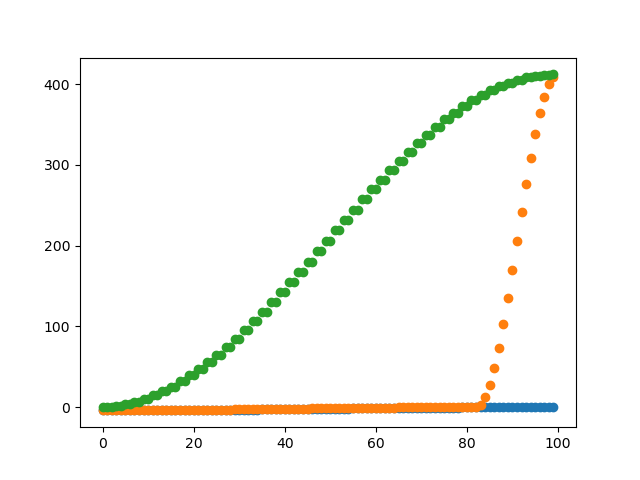

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

N = 100
L = np.diag(-2 * np.ones(N), k=0) + np.diag(np.ones(N-1), k = 1) +np.diag(np.ones(N-1), k = -1)
L[0,N-1] = L[N-1, 0] = 1
a = np.ones(N)
a[N//3:N//2] = -103.0
fig, ax = plt.subplots()
ax.plot(np.sort(np.linalg.eigvals(L)), 'o')
ax.plot(np.sort(np.linalg.eigvals(L @ np.diag(a))), 'o')
ax.plot(np.sort(np.linalg.eigvals(-103.0 * L)), 'o')

# eigenvalues, eigenvectors = np.linalg.eig(L @ np.diag(a))
# index_of_largest = np.argmax(eigenvalues)
# largest_eigenvector = eigenvectors[:, index_of_largest]

# ax.plot(np.abs(largest_eigenvector), '-o')
# ax.set_yscale('log')
# print(np.linalg.eigvals(L @ np.diag(a)))

In [16]:
largest_eigenvector

array([-2.35616040e-17,  9.93335733e-17,  6.57427144e-17,  7.70788044e-19,
        1.51524944e-16,  9.88167264e-17,  1.39308395e-16,  2.46060637e-17,
        2.06469555e-16,  2.65318722e-16,  1.44854127e-16,  2.12054063e-16,
        1.15489346e-16,  5.77242981e-17, -5.36395564e-17,  1.04675811e-17,
       -7.53023968e-17,  5.28491826e-17,  2.57657128e-18, -1.21483955e-16,
        1.87072634e-16,  7.97207057e-17,  1.61482256e-16, -5.30129911e-17,
       -1.15074854e-16, -1.11647838e-16, -5.23970458e-15, -1.07052967e-12,
       -2.21634323e-10, -4.58783000e-08, -9.49680808e-06, -1.96583927e-03,
       -4.06928729e-01,  8.17808223e-01, -4.06928729e-01, -1.96583927e-03,
       -9.49680808e-06, -4.58782999e-08, -2.21634299e-10, -1.07069710e-12,
       -5.17244974e-15, -2.49876799e-17, -1.20713430e-19, -5.83156619e-22,
       -2.81718888e-24, -1.36086996e-26, -6.58348000e-29, -3.11023171e-31,
       -1.85780533e-33,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.80369449e-35, -

iter #: 1 A solution was found at the specified tolerance. Norm error = 3.87e-05 Dot prod err: 5.19e-01
iter #: 2 A solution was found at the specified tolerance. Norm error = 4.26e-04 Dot prod err: 6.47e-13
iter #: 3 A solution was found at the specified tolerance. Norm error = 8.12e-04 Dot prod err: 6.38e-11
iter #: 4 A solution was found at the specified tolerance. Norm error = 1.20e-03 Dot prod err: 1.10e-10
iter #: 5 A solution was found at the specified tolerance. Norm error = 1.58e-03 Dot prod err: 1.03e-10
iter #: 6 A solution was found at the specified tolerance. Norm error = 1.97e-03 Dot prod err: 1.70e-10
iter #: 7 A solution was found at the specified tolerance. Norm error = 2.36e-03 Dot prod err: 9.57e-11
iter #: 8 A solution was found at the specified tolerance. Norm error = 2.74e-03 Dot prod err: 9.03e-11
iter #: 9 A solution was found at the specified tolerance. Norm error = 3.13e-03 Dot prod err: 1.21e-10
iter #: 10 A solution was found at the specified tolerance. Norm

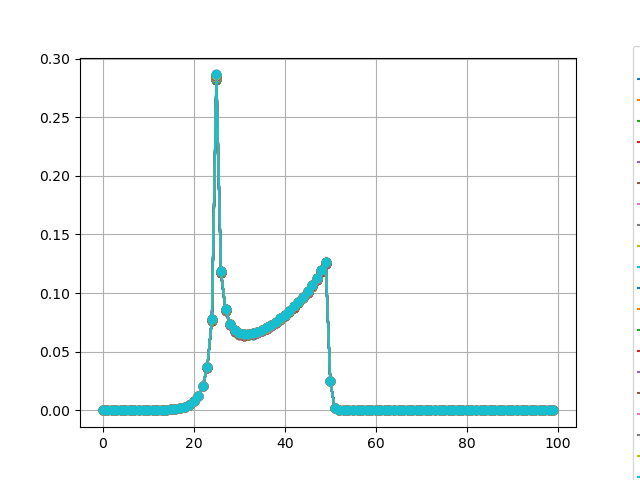

In [26]:
n_cont = 50
ds = 0.0002 * np.ones(n_cont)
ds[0] *= 1e-1

epsilon_prev = 1.7e-1
kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)
g_array = kappa * np.exp(- k * bin_edges) + eps * bin_edges
g_int_array = g(bin_centers, kappa, k, eps)
x_s_prev = np.ones(n_bins+1)/np.sqrt(n_bins+1)
# x_s_prev[-1] *= 0.01

# plt.close('all')
fig, ax = plt.subplots()
ax.plot(P, 'o', label='Initial P')
P_prev = P.copy()
for i in range(n_cont):
    G_x = RHS_jac(P_prev, g_int_array, g_array, rate_matrix)
    G_L = RHS_epsilon(P_prev, g_int_array, g_array, rate_matrix)

    E_x = np.block([
        [G_x, G_L[:, None]],
        [x_s_prev[:-1], x_s_prev[-1]]
    ])

    G_s = np.zeros((n_bins+1))
    G_s[-1] = 1.0

    x_s_new = np.linalg.solve(E_x, G_s)
    # x_s_new = np.sign(np.sum(x_s_new * x_s_prev))*x_s_new/np.linalg.norm(x_s_new)
    x_s_new = x_s_new/np.linalg.norm(x_s_new)

    P_new = P_prev + ds[i] * x_s_new[:-1]/np.linalg.norm(x_s_new)
    epsilon_new = epsilon_prev + ds[i] * x_s_new[-1]/np.linalg.norm(x_s_new)
    # kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon_new, r)
    # g_array = kappa * np.exp(- k * bin_edges) + eps * bin_edges
    # g_int_array = g(bin_centers, kappa, k, eps)

    def _temp(_x):
        kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, _x[-1], r)
        g_array = kappa * np.exp(- k * bin_edges) + eps * bin_edges
        g_int_array = g(bin_centers, kappa, k, eps)
        return np.hstack([RHS(_x[:-1], g_int_array, g_array, rate_matrix), 
                        #   np.sum(x_s_prev * (_x - np.hstack([P_prev, epsilon_prev]))) - ds[i]])
                          np.sum((_x - np.hstack([P_prev, epsilon_prev]))**2) - ds[i]**2])
    
    # def _temp_jac(_x):
    #     kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, _x[-1], r)
    #     g_array = kappa * np.exp(- k * bin_edges) + eps * bin_edges
    #     g_int_array = g(bin_centers, kappa, k, eps)
    #     return np.block([
    #         [RHS_jac(_x[:-1], g_int_array, g_array, rate_matrix), RHS_epsilon(_x[:-1], g_int_array, g_array, rate_matrix)],
    #         [x_s_new[:-1], x_s_new[-1]]
    #         ])
    res = root(_temp, x0=np.hstack([P_new, epsilon_new]), method='krylov', options={'xatol':1e-8, 'maxiter':50000})
    print(f'iter #: {i+1}', res.message, f'Norm error = {np.abs(1 - np.sum(res.x[:-1] * dx)):.2e}', f'Dot prod err: {1 - np.sum(x_s_new * x_s_prev):.2e}')
    P_prev = res.x[:-1]
    epsilon_prev = res.x[-1]
    x_s_prev = x_s_new.copy()

    # ax.plot(ds * x_s_new, 'o-.', c=f'C{i}', label=f'D P {i}')
    # ax.plot(P_new, 'o--', c=f'C{i}', label=f'P guess {i}')
    ax.plot(P_prev, 'o-', c=f'C{i}', label=f'P, e = {epsilon_prev:.2e}')

# ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.grid()
plt.show()

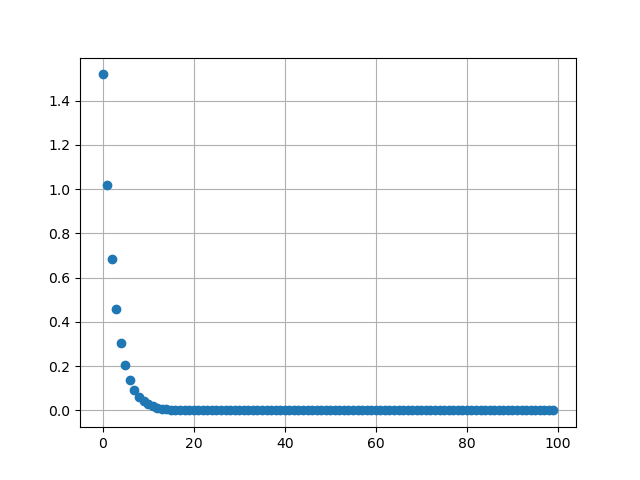

In [ ]:
J = RHS_jac(P, g_int_array, g_array, rate_matrix)

eigenvalues, eigenvectors = np.linalg.eig(J)
# Find the index of the largest eigenvalue
index_of_largest = np.argmax(eigenvalues)

# Get the corresponding eigenvector
largest_eigenvector = eigenvectors[:, index_of_largest]

fig, ax = plt.subplots()
# ax.imshow(rate_matrix)
# ax.imshow(np.log(np.abs(dynamics_matrix)))
# ax.plot(bin_centers, largest_eigenvector, 'o')
ax.plot(np.abs(eigenvalues), 'o')
# ax.set_yscale('log')
ax.grid()

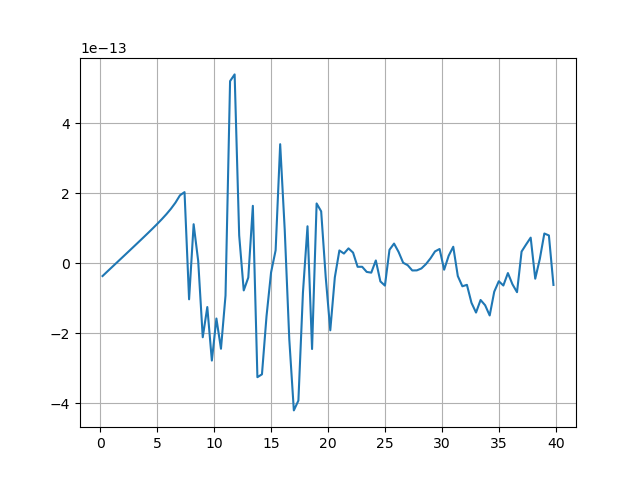

In [ ]:
fig, ax = plt.subplots()
# ax.bar(bin_centers, res.x)
# ax.plot(bin_centers, res1.x)
ax.plot(bin_centers, RHS(res.x, g_int_array, g_array, rate_matrix))
# ax.set_yscale('log')
ax.grid()

No handles with labels found to put in legend.


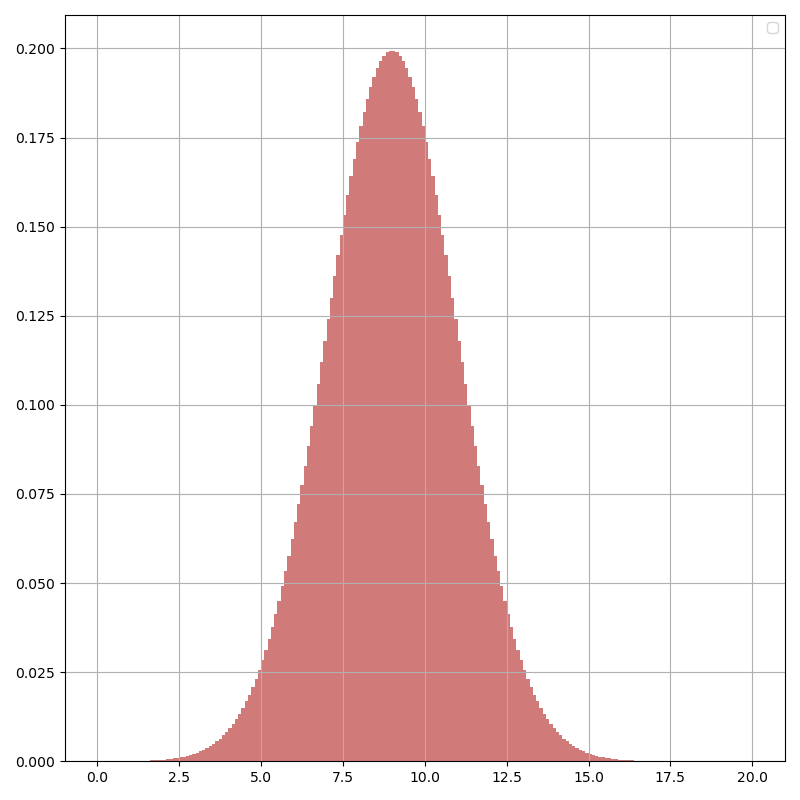

No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6
No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6
No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6
No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6
No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6
No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6
No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6
No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6
No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6
No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6
No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6
No such comm: 6a8ef66adc0c4b0ea9dbbd4aefb729e6


In [ ]:
from matplotlib.animation import FuncAnimation
# Initialize plot
plt.close('all')
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
time_text = ax1.text(0.02, 0.93, '', transform=ax1.transAxes)
ax1.legend()
ax1.grid()

# Variables to store statistics over time
times = []

dt = 0.01
n_steps = 10_000
stride = 1000
mu, sig = 9, 2
P_ini = 1/np.sqrt(2*np.pi*sig**2) * np.exp(-0.5*(bin_centers - mu)**2/sig**2)
bars = ax1.bar(bin_centers, P_ini, width=dx, color='firebrick', alpha=0.6)

P = P_ini.copy()

# Update function for animation
t = 0
frame = 1
def update(frame):
    global P, t, times
    _stride = stride #if frame > 0 else 1
    t += _stride * dt
    for i in range(_stride):
        if i % _stride== 0:
            v_array = np.sum(g(bin_centers, kappa, k, eps) * P) / np.sum(P) - g(bin_edges, kappa, k, eps)
            theta_array = v_array > 0

            dynamics_matrix = np.diag(v_array[:-1] * (1 - theta_array[:-1]) - v_array[1:] * theta_array[1:], k=0)
            dynamics_matrix += np.diag(v_array[1:-1] * theta_array[1:-1], k=-1)
            dynamics_matrix += np.diag(-v_array[get_dynamics_matrix1:-1] * (1 - theta_array[1:-1]), k=1)        
        
        P += dt * (dynamics_matrix + rate_matrix) @ P
# P, stats = fv.evolve_P(_stride, _stride, P, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=False)
    
    # Update the bar heights
    for bar, height in zip(bars, P):
        bar.set_height(height)
    
    # Update text annotations
    time_text.set_text(f'Time: {t:.3e} / {(dt * n_steps * stride):.2e}')
    
    # Append new statistics
    times.append(t)
    
    ax1.set_xlim(0, 0.7*np.max(bin_edges))
    ax1.set_ylim(-0.05, 0.5)
    

    return bars, time_text

# Create animation
ani = FuncAnimation(fig, update, frames=n_steps, blit=True, repeat=False, interval=1)
# ani.save('works5.gif')

# Display animation
plt.tight_layout()
plt.show()


In [ ]:
dt = 1
n_steps = 1_000_000
stride = 1
mu, sig = 9, 2
P_ini = 1/np.sqrt(2*np.pi*sig**2) * np.exp(-0.5*(bin_centers - mu)**2/sig**2)
thetas = []
P = P_ini.copy()
for j in tqdm(range(n_steps)):
    # for i in range(stride):
    #     if i % stride== 0:
    v_array = np.sum(g(bin_centers, kappa, k, eps) * P) / np.sum(P) - g(bin_edges, kappa, k, eps)
    theta_array = v_array > 0

    dynamics_matrix = np.diag(v_array[:-1] * (1 - theta_array[:-1]) - v_array[1:] * theta_array[1:], k=0)
    dynamics_matrix += np.diag(v_array[1:-1] * theta_array[1:-1], k=-1)
    dynamics_matrix += np.diag(-v_array[1:-1] * (1 - theta_array[1:-1]), k=1)

    root_ind = np.min(np.where(np.logical_xor(theta_array[:-1], theta_array[1:]))[0])
    theta = v_array[root_ind+1]*(P[root_ind+1]-P[root_ind]) / (v_array[root_ind+1]*P[root_ind+1] - v_array[root_ind]*P[root_ind-1] + P[root_ind]*(v_array[root_ind+1] - v_array[root_ind]))
    # thetas.append(theta)            # assert theta >= 0 and theta <= 1.0
    dynamics_matrix[root_ind, root_ind-1] = theta * v_array[root_ind]
    dynamics_matrix[root_ind, root_ind]   = (1 - theta) * v_array[root_ind] - theta * v_array[root_ind+1]
    dynamics_matrix[root_ind, root_ind+1] = -(1 - theta) * v_array[root_ind+1]

    P += dt * (dynamics_matrix + rate_matrix) @ P


100%|██████████| 1000000/1000000 [06:21<00:00, 2621.60it/s]


/tmp/ipykernel_2840827/1175643820.py:15: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(np.abs(dynamics_matrix)))


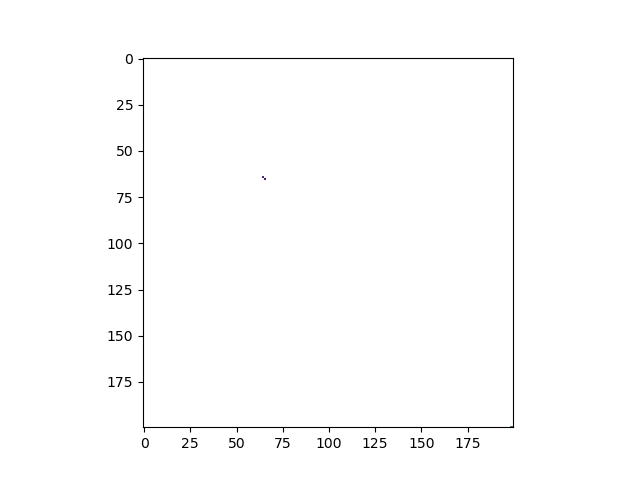

In [ ]:
v_array = np.sum(g(bin_centers, kappa, k, eps) * P) / np.sum(P) - g(bin_edges, kappa, k, eps)
theta_array = v_array > 0

dynamics_matrix = np.diag(v_array[:-1] * (1 - theta_array[:-1]) - v_array[1:] * theta_array[1:], k=0)
dynamics_matrix += np.diag(v_array[1:-1] * theta_array[1:-1], k=-1)
dynamics_matrix += np.diag(-v_array[1:-1] * (1 - theta_array[1:-1]), k=1)


fig, ax = plt.subplots()
ax.imshow(np.log(np.abs(dynamics_matrix)))

No handles with labels found to put in legend.
/usr/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


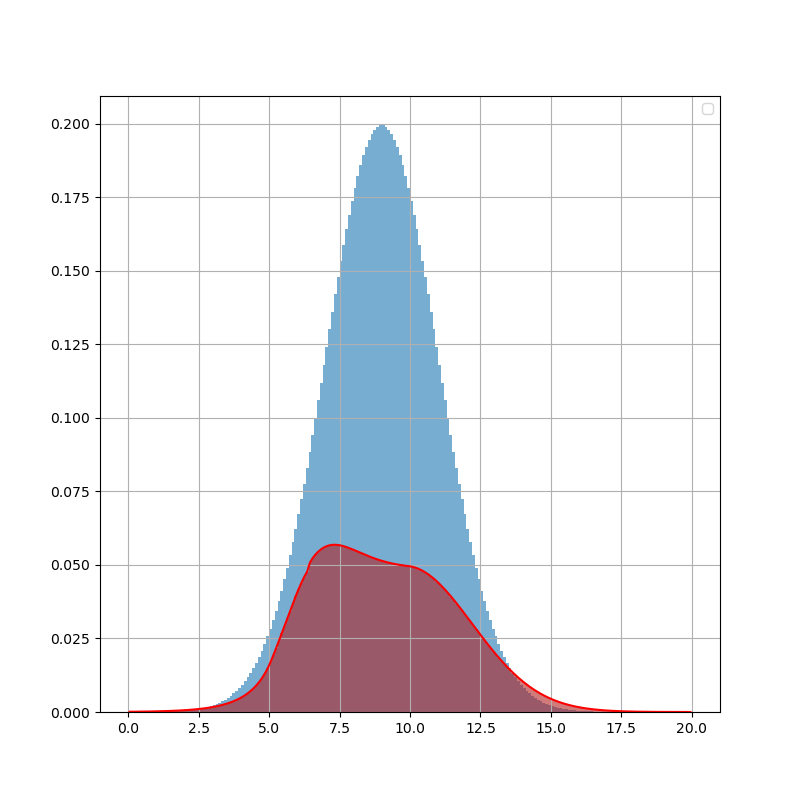

In [ ]:
plt.close('all')
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
time_text = ax1.text(0.02, 0.93, '', transform=ax1.transAxes)
ax1.legend()
ax1.grid()

bars = ax1.bar(bin_centers, P_ini, width=dx, linewidth=3, alpha=0.6)
bars = ax1.bar(bin_centers, P, width=dx, color='firebrick', alpha=0.6)
ax1.plot(bin_centers, largest_eigenvector*np.max(P)/np.max(largest_eigenvector), 'r')


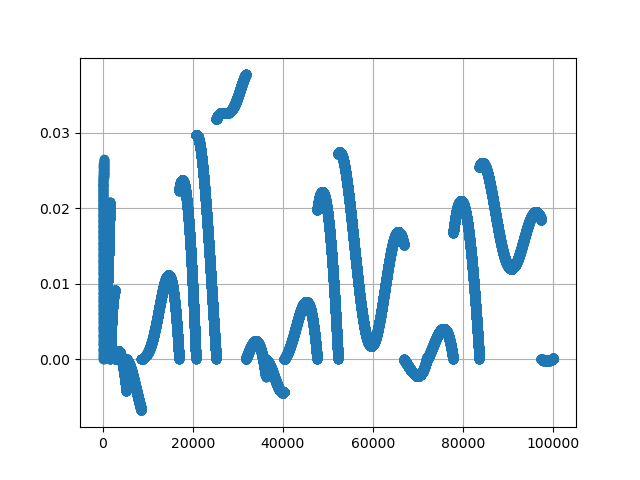

In [ ]:
fig, ax = plt.subplots()
ax.plot(thetas, 'o')
# ax.set_yscale('log')
ax.grid()

In [ ]:
print(np.sum(P * dx))

print(np.sum(bin_centers * P_ini * dx)/ np.sum(P_ini * dx))
print(np.sum(bin_centers * P * dx) / np.sum(P * dx))

0.38978553716147907
9.000031688819407
9.041926309016874


In [ ]:
v_array = np.sum(g(bin_centers, kappa, k, eps) * P) / np.sum(P) - g(bin_edges, kappa, k, eps)
theta_array = v_array > 0

dynamics_matrix = np.diag(v_array[:-1] * (1 - theta_array[:-1]) - v_array[1:] * theta_array[1:], k=0)
dynamics_matrix += np.diag(v_array[1:-1] * theta_array[1:-1], k=-1)
dynamics_matrix += np.diag(-v_array[1:-1] * (1 - theta_array[1:-1]), k=1)


In [ ]:
plt.close('all')

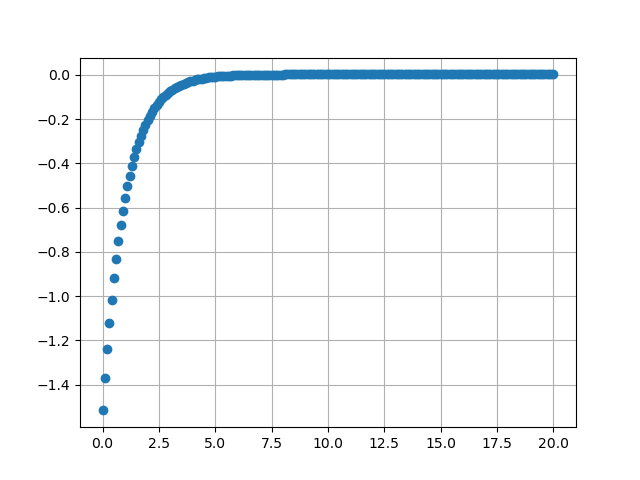

In [ ]:
fig, ax = plt.subplots()
# ax.imshow(rate_matrix)
# ax.imshow(np.log(np.abs(dynamics_matrix)))
ax.plot(bin_edges, -v_array, 'o')
# ax.set_yscale('log')
ax.grid()

/usr/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


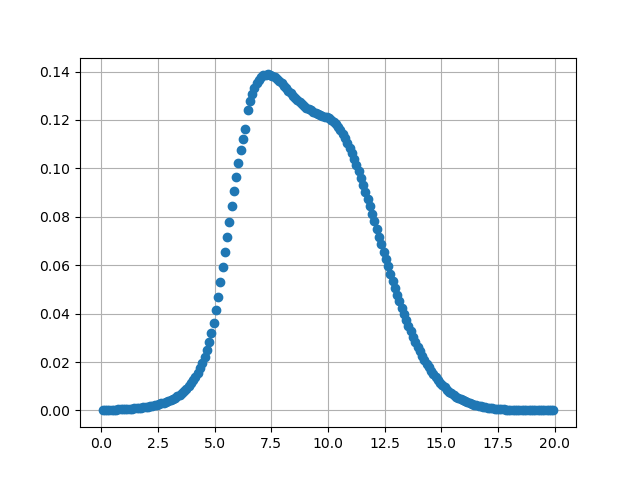

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(dynamics_matrix + rate_matrix)
# Find the index of the largest eigenvalue
index_of_largest = np.argmax(eigenvalues)

# Get the corresponding eigenvector
largest_eigenvector = eigenvectors[:, index_of_largest]

fig, ax = plt.subplots()
# ax.imshow(rate_matrix)
# ax.imshow(np.log(np.abs(dynamics_matrix)))
ax.plot(bin_centers, largest_eigenvector, 'o')
# ax.set_yscale('log')
ax.grid()


100%|██████████| 300/300 [00:08<00:00, 36.81it/s]
/usr/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


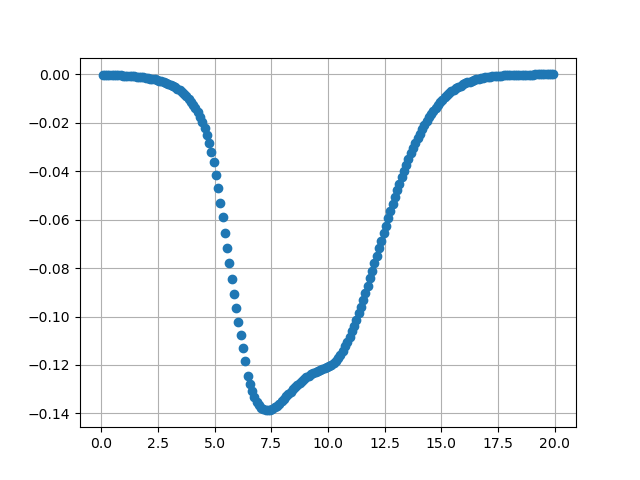

In [ ]:
n_steps_ev = 300
a = []
b = []
P = P_ini.copy()

g_int_array = kappa * np.exp(- k * bin_centers) * np.sinh(0.5 * k * dx) / (0.5 * k * dx) + eps * bin_centers
for i in tqdm(range(n_steps_ev)):
    v_array = np.sum(g_int_array * P) / np.sum(P) - g(bin_edges, kappa, k, eps)
    theta_array = v_array > 0

    dynamics_matrix = np.diag(v_array[:-1] * (1 - theta_array[:-1]) - v_array[1:] * theta_array[1:], k=0)
    dynamics_matrix += np.diag(v_array[1:-1] * theta_array[1:-1], k=-1)
    dynamics_matrix += np.diag(-v_array[1:-1] * (1 - theta_array[1:-1]), k=1)

    root_ind = np.min(np.where(np.logical_xor(theta_array[:-1], theta_array[1:]))[0])
    theta = v_array[root_ind+1]*(P[root_ind+1]-P[root_ind]) / (v_array[root_ind+1]*P[root_ind+1] - v_array[root_ind]*P[root_ind-1] + P[root_ind]*(v_array[root_ind+1] - v_array[root_ind]))
    # thetas.append(theta)            # assert theta >= 0 and theta <= 1.0

    eigenvalues, eigenvectors = np.linalg.eig(dynamics_matrix + rate_matrix)
    # Find the index of the largest eigenvalue
    index_of_largest = np.argmax(eigenvalues)
    a.append(eigenvalues)
    # Get the corresponding eigenvector
    largest_eigenvector = eigenvectors[:, index_of_largest]
    P = np.real(largest_eigenvector)
fig, ax = plt.subplots()
# ax.imshow(rate_matrix)
# ax.imshow(np.log(np.abs(dynamics_matrix)))
ax.plot(bin_centers, largest_eigenvector, 'o')
# ax.set_yscale('log')
ax.grid()

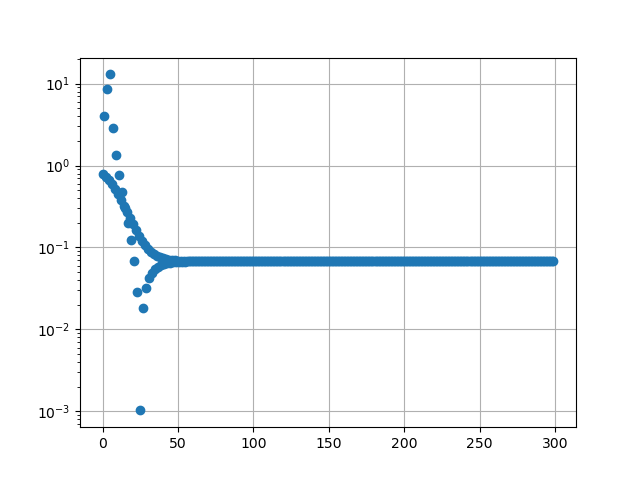

In [ ]:
fig, ax = plt.subplots()
ax.plot([np.abs(np.sort(np.real(ai))[-1]/np.sort(np.real(ai))[-2]) for ai in a], 'o')
ax.grid()
ax.set_yscale('log')

In [ ]:
np.sort(eigenvalues)[-3:]

array([-1.30287163e-05-0.00020271j, -1.30287163e-05+0.00020271j,
       -8.84866567e-07+0.j        ])

In [ ]:
np.mean((dynamics_matrix + rate_matrix) @ P)

4.21679853518666e-08